In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# def activation(name):
#     if name in ['tanh', 'Tanh']:
#         return nn.Tanh()
#     elif name in ['relu', 'ReLU']:
#         return nn.ReLU(inplace=True)
#     elif name in ['lrelu', 'LReLU']:
#         return nn.LeakyReLU(inplace=True)
#     elif name in ['sigmoid', 'Sigmoid']:
#         return nn.Sigmoid()
#     elif name in ['softplus', 'Softplus']:
#         return nn.Softplus(beta=4)
#     elif name in ['celu', 'CeLU']:
#         return nn.CELU()
#     elif name in ['elu']:
#         return nn.ELU()
#     elif name in ['mish']:
#         return nn.Mish()
#     else:
#         raise ValueError('Unknown activation function')




# ################################################################
# #  1d fourier layer
# ################################################################
# class SpectralConv1d(nn.Module):
#     def __init__(self, in_channels, out_channels, modes1):
#         super(SpectralConv1d, self).__init__()

#         """
#         1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
#         """

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.modes1 = modes1

#         self.scale = (1 / (in_channels * out_channels))
#         self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

#     # Complex multiplication
#     def compl_mul1d(self, input, weights):
#         print('\n-----------------')
#         print("I AM IN COMPL_MUL1D")
#         print('-----------------')
#         # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
#         print("input.shape: ", input.shape)
#         print("weights.shape: ", weights.shape)
#         return torch.einsum("bix,iox->box", input, weights)


# ######################### TO DO ####################################


#     def forward(self, x):
#         batchsize = x.shape[0]

#         print('\n-----------------')
#         print("I AM IN FORWARD FOURIER")
#         print('-----------------')

#         print("batchsize: ", batchsize)
#         print("x.shape appena dentro forward di SpectralConv1d: ", x.shape)

#         # x.shape == [batch_size, in_channels, number of grid points]
#         # hint: use torch.fft library torch.fft.rfft
#         # use DFT to approximate the fourier transform
        
#         # Compute Fourier coefficients
#         x_ft = torch.fft.rfft(x)
#         print("x_ft.shape: ", x_ft.shape)

#         # Multiply relevant Fourier modes
#         out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
#         print('out_ft.shape: ', out_ft.shape)

#         print("\nWhat I pass to compl_mul1d: ")
#             # # ad to x_ft the dim of the in_channels (which is 1)
#             # x_ft = x_ft.unsqueeze(1)
#         print("x_ft[:, :, :self.modes1].shape: ", x_ft[:, :, :self.modes1].shape)
#         print("self.weights1.shape: ", self.weights1.shape)
        
#         out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

#         # Return to physical space
#         x = torch.fft.irfft(out_ft, n=x.size(-1))

#         print('\nReturn to physical space')
#         print("x.shape: ", x.shape)
#         return x


# ####################################################################


# class FNO1d(nn.Module):
#     def __init__(self, modes, width):
#         super(FNO1d, self).__init__()

#         """
#         The overall network. It contains 4 layers of the Fourier layer.
#         1. Lift the input to the desire channel dimension by self.fc0 .
#         2. 4 layers of the integral operators u' = (W + K)(u).
#             W defined by self.w; K defined by self.conv .
#         3. Project from the channel space to the output space by self.fc1 and self.fc2 .

#         input: the solution of the initial condition and location (a(x), x)
#         input shape: (batchsize, x=s, c=2)
#         output: the solution of a later timestep
#         output shape: (batchsize, x=s, c=1)
#         """

#         self.modes1 = modes
#         self.width = width
#         self.padding = 1  # pad the domain if input is non-periodic
#         self.linear_p = nn.Linear(1, self.width)  # input channel is 1

#         self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
#         self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
#         self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
#         self.lin0 = nn.Conv1d(self.width, self.width, 1)
#         self.lin1 = nn.Conv1d(self.width, self.width, 1)
#         self.lin2 = nn.Conv1d(self.width, self.width, 1)

#         self.linear_q = nn.Linear(self.width, 32)
#         self.output_layer = nn.Linear(32, 1)

#         self.activation = torch.nn.Tanh()

#     def fourier_layer(self, x, spectral_layer, conv_layer):
#         print('DIO')
#         print('Spectral layer output shape GUGO: ', spectral_layer(x).shape)
#         print('DIO')
#         print('Conv layer output shape: ', conv_layer(x).shape)
#         print('-----------------')
#         return self.activation(spectral_layer(x) + conv_layer(x))

#     def linear_layer(self, x, linear_transformation):
#         return self.activation(linear_transformation(x))

#     def forward(self, x):
#         # grid = self.get_grid(x.shape, x.device)
#         # x = torch.cat((x, grid), dim=-1)
#         print('-----------------')
#         print("I AM IN FORWARD")
#         print('-----------------')
#         print("x.shape: ", x.shape)
#         x = self.linear_p(x)
#         print("x.shape post linear_p: ", x.shape)
#         # x = x.permute(0, 2, 1)
#         # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

#         x = self.fourier_layer(x, self.spect1, self.lin0)
#         print("x.shape post fourier_layer: ", x.shape)
#         x = self.fourier_layer(x, self.spect2, self.lin1)
#         x = self.fourier_layer(x, self.spect3, self.lin2)

#         # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
#         x = x.permute(0, 2, 1)

#         x = self.linear_layer(x, self.linear_q)
#         x = self.output_layer(x)
#         return x

In [3]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')




################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


######################### TO DO ####################################


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

Text(0.5, 1.0, 'Normalized data')

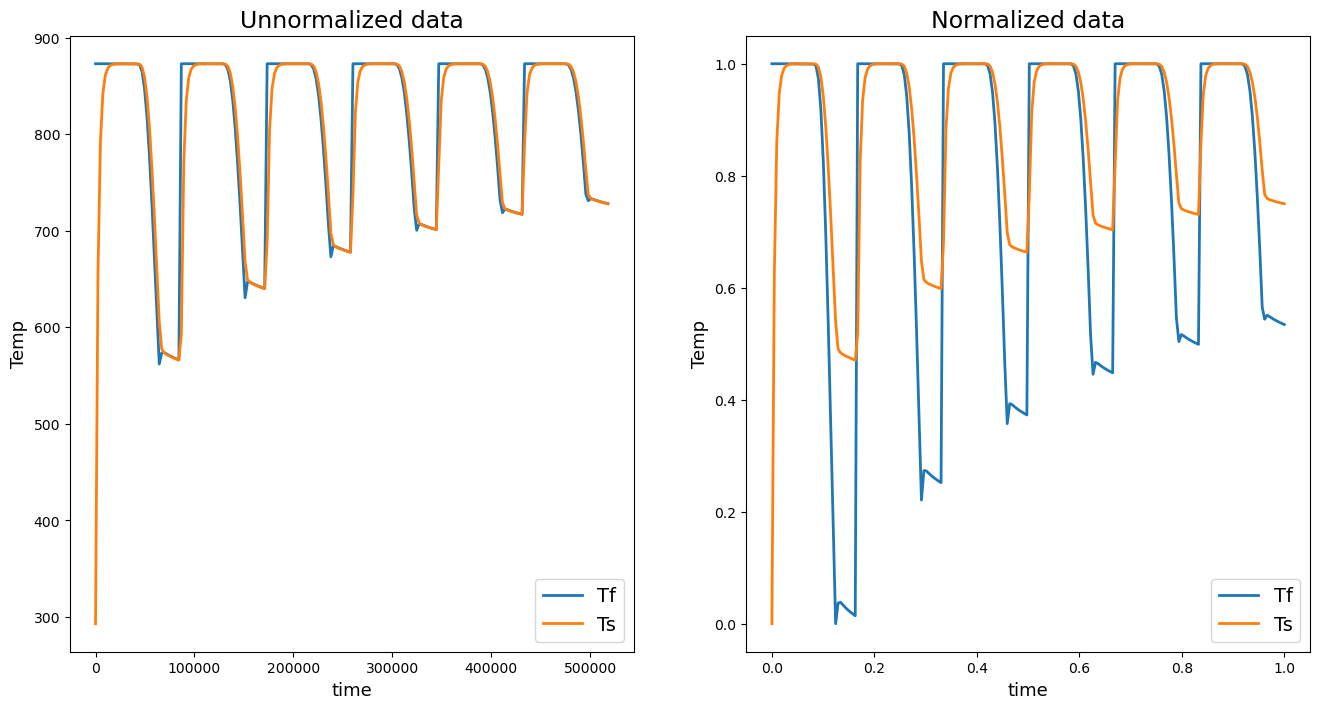

In [4]:
# Load the data from the file
df_data = pd.read_csv('TrainingData.txt')

# Unnormalized data
t_data = torch.tensor(df_data['t'].values, dtype=torch.float)
Tf_data = torch.tensor(df_data['tf0'].values, dtype=torch.float)
Ts_data = torch.tensor(df_data['ts0'].values, dtype=torch.float)

# Normalized data
t_data_norm = (t_data - t_data.min()) / (t_data.max() - t_data.min())
Tf_data_norm = (Tf_data - Tf_data.min()) / (Tf_data.max() - Tf_data.min())
Ts_data_norm = (Ts_data - Ts_data.min()) / (Ts_data.max() - Ts_data.min())


# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# unnormalized data
axs[0].plot(t_data, Tf_data, label='Tf', linewidth=2)
axs[0].plot(t_data, Ts_data, label='Ts', linewidth=2)
axs[0].set_xlabel('time', size=13)
axs[0].set_ylabel('Temp', size=13)
axs[0].legend(fontsize=14)
axs[0].set_title('Unnormalized data', size=17)

# normalized data
axs[1].plot(t_data_norm, Tf_data_norm, label='Tf', linewidth=2)
axs[1].plot(t_data_norm, Ts_data_norm, label='Ts', linewidth=2)
axs[1].set_xlabel('time', size=13)
axs[1].set_ylabel('Temp', size=13)
axs[1].legend(fontsize=14)
axs[1].set_title('Normalized data', size=17)

In [5]:
# Devide the data into training and testing
train_perc = 0.8

t_train = t_data[:int(len(t_data)*train_perc)].reshape(-1, 1)
Tf_train = Tf_data[:int(len(Tf_data)*train_perc)].reshape(-1, 1)
Ts_train = Ts_data[:int(len(Ts_data)*train_perc)].reshape(-1, 1)

t_test = t_data[int(len(t_data)*train_perc):].reshape(-1, 1)
Tf_test = Tf_data[int(len(Tf_data)*train_perc):].reshape(-1, 1)
Ts_test = Ts_data[int(len(Ts_data)*train_perc):].reshape(-1, 1)

print('Training data size:\t', len(t_train))
print('Testing data size:\t', len(t_test))

# Define the batch size and load the Dataset
batch_size = 7  # other option 14 or 21

# For Tf
training_set_Tf = DataLoader(TensorDataset(t_test, Tf_test), batch_size=batch_size, shuffle=True)
testing_set_Tf = DataLoader(TensorDataset(t_test, Tf_test), batch_size=batch_size, shuffle=True)

# For Ts
training_set_Ts = DataLoader(TensorDataset(t_test, Ts_test), batch_size=batch_size, shuffle=False)
testing_set_Ts = DataLoader(TensorDataset(t_test, Ts_test), batch_size=batch_size, shuffle=False)

Training data size:	 168
Testing data size:	 42


In [5]:
for step, (input_batch, output_batch) in enumerate(training_set_Tf):
    if step == 0:
        print('input_batch.shape: ', input_batch.shape)
        print('output_batch.shape: ', output_batch.shape)

input_batch.shape:  torch.Size([7, 1, 1])
output_batch.shape:  torch.Size([7, 1, 1])


In [6]:
learning_rate = 0.001

# epochs = 250
epochs = 2
step_size = 50
gamma = 0.5

modes = 16
width = 64

# model

fno_Tf = FNO1d(modes, width)
fno_Ts = FNO1d(modes, width)

In [7]:
# Train the Tf FNO
optimizer = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)

    scheduler.step()

    with torch.no_grad():
        fno_Tf.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_Tf):
            output_pred_batch = fno_Tf(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_Tf)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


-----------------
I AM IN FORWARD
-----------------
x.shape:  torch.Size([7, 1, 1])
x.shape post linear_p:  torch.Size([7, 1, 64])
DIO

-----------------
I AM IN FORWARD FOURIER
-----------------
batchsize:  7
x.shape appena dentro forward di SpectralConv1d:  torch.Size([7, 1, 64])
x_ft.shape:  torch.Size([7, 1, 33])
out_ft.shape:  torch.Size([7, 64, 33])

What I pass to compl_mul1d: 
x_ft[:, :, :self.modes1].shape:  torch.Size([7, 1, 16])
self.weights1.shape:  torch.Size([64, 64, 16])

-----------------
I AM IN COMPL_MUL1D
-----------------
input.shape:  torch.Size([7, 1, 16])
weights.shape:  torch.Size([64, 64, 16])

Return to physical space
x.shape:  torch.Size([7, 64, 64])
Spectral layer output shape GUGO:  torch.Size([7, 64, 64])
DIO


RuntimeError: Given groups=1, weight of size [64, 64, 1], expected input[7, 1, 64] to have 64 channels, but got 1 channels instead

In [ ]:
idx_data = 134
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
print(input_function_test_n.shape)
print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n)
print(output_function_test_pred_n.shape)
print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C0")
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()

NameError: name 'input_function_test' is not defined

In [ ]:
import torch
import torch.nn as nn

# Define your model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1d = nn.Conv1d(64, 5, 1)

    def forward(self, x):
        # Apply the convolutional layer
        out = self.conv1d(x)
        return out

# Create an instance of your model
model = MyModel()

# Generate random input tensor
input_channels = 64
input_length = 100
x = torch.randn(input_channels, input_length)
print(x.shape)
# Pass the input through the model
output = model(x)

# Print the shape of the output tensor
print("Output shape:", output.shape)


torch.Size([64, 100])
Output shape: torch.Size([5, 100])
